# AED & EEG

## Install libraries

In [1]:
import matlab.engine

import math
import os
import re

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

from scipy import stats, io, interpolate
from scipy.fft import fft

import numpy as np
from numpy import pi, NaN

import pickle

from signal_processing import *

## Load data

In [2]:
patients_df = pd.read_excel("./data/selected_patients.xlsx")
patients_df

,hup_id,region,lateralization,weight_kg,r_id
0,138,mesial temporal,left,84.4,278
1,140,mesial temporal,left,56.7,320
2,141,mesial temporal,right,85.7,294
3,142,mesial temporal,left,65.3,295
4,162,mesial temporal,left,47.1,412
5,163,mesial temporal,left,82.1,279
6,164,mesial temporal,left,95.3,386
7,173,mesial temporal,right,76.6,31
8,181,mesial temporal,left,63.0,490
9,185,mesial temporal,left,76.2,332


In [3]:
# Load master_elecs.csv from ./data/
master_elecs_df = pd.read_csv("./data/master_elecs.csv")

# only take the numbers in rid column
master_elecs_df["rid"] = master_elecs_df["rid"].str.extract("(\d+)", expand=False)
master_elecs_df["rid"] = master_elecs_df["rid"].astype(int)

# Drop mni_x, mni_y, mni_z, mm_x, mm_y, mm_z columns
master_elecs_df = master_elecs_df.drop(
    columns=["mni_x", "mni_y", "mni_z", "mm_x", "mm_y", "mm_z"]
)

master_elecs_df

,rid,name,vox_x,vox_y,vox_z,label,soz,resected,spike_rate,engel
0,13,LST01,80.6116,106.5480,64.5941,left inferior temporal,False,False,1.091902,1.0
1,13,LST02,72.0779,109.4150,63.1223,left inferior temporal,False,False,1.091902,1.0
2,13,LST03,64.9060,112.3760,68.7455,EmptyLabel,False,False,1.419472,1.0
3,13,LST04,65.0210,114.6600,78.2339,left middle temporal,False,False,0.655141,1.0
4,13,MST01,131.7410,64.3756,70.4205,right lingual,True,False,3.439490,1.0
...,...,...,...,...,...,...,...,...,...,...
14212,785,RB08,154.2550,114.2730,136.7560,EmptyLabel,False,NaN,0.369914,1.0
14213,785,RB09,159.1350,111.9920,136.6960,EmptyLabel,False,NaN,0.665845,1.0
14214,785,RB10,164.7520,109.9030,137.7640,right middle temporal,False,NaN,4.586930,1.0
14215,785,RB11,169.6320,107.6220,137.7040,right middle temporal,False,NaN,2.071517,1.0


In [4]:
# Load rid_hup_table.csv from ./data/
rid_hup_table_df = pd.read_csv("./data/rid_hup_table.csv")
# Drop the t3_subject_id and ieegportalsubjno columns
rid_hup_table_df = rid_hup_table_df.drop(columns=["t3_subject_id", "ieegportalsubjno"])
rid_hup_table_df

,record_id,hupsubjno
0,623,35
1,624,36
2,625,37
3,626,38
4,627,39
...,...,...
212,534,250
213,923,251
214,918,252
215,864,253


In [5]:
# Load aed_ref_ranges.xlsx from ./data/
aed_ref_ranges_df = pd.read_excel("./data/aed_ref_ranges.xlsx")
# Lowercase Drug column
aed_ref_ranges_df["Drug"] = aed_ref_ranges_df["Drug"].str.lower()
# show unique units
# print(aed_ref_ranges_df["Unit"].unique())
# mg/L and ug/mL are the same
# If Unit is ng/mL, convert to ug/mL
aed_ref_ranges_df.loc[aed_ref_ranges_df["Unit"] == "ng/mL", "Min"] = (
    aed_ref_ranges_df["Min"] / 1000
)
aed_ref_ranges_df.loc[aed_ref_ranges_df["Unit"] == "ng/mL", "Max"] = (
    aed_ref_ranges_df["Max"] / 1000
)
# Add a column that takes the average of Min and Max
aed_ref_ranges_df["Avg"] = (aed_ref_ranges_df["Min"] + aed_ref_ranges_df["Max"]) / 2
aed_ref_ranges_df

,Drug,Min,Max,Unit,Avg
0,levetiracetam,12.00,46.00,mg/L,29.000
1,carbamazepine,4.00,10.00,mg/L,7.000
2,oxcarbazepine,3.00,35.00,ug/mL,19.000
3,clobazam,0.03,0.30,ng/mL,0.165
4,n-desmethylclobazam,0.30,3.00,ng/mL,1.650
5,topiramate,5.00,20.00,mg/L,12.500
6,valproic acid,50.00,125.00,ug/mL,87.500
7,lacosamide,1.00,10.00,ug/mL,5.500
8,felbamate,30.00,60.00,ug/mL,45.000
9,lamotrigine,2.50,15.00,mg/L,8.750


In [6]:
patient_hup_ids = patients_df.hup_id.to_numpy()
patient_weights = patients_df.weight_kg.to_numpy()
assert len(patient_hup_ids) == len(patient_weights)
len(patient_hup_ids)

18

In [7]:
all_patient_hup_ids = pd.read_excel("./data/HUP_implant_dates.xlsx")
all_patient_hup_ids = all_patient_hup_ids["ptID"].to_numpy()
all_patient_hup_ids

array([225, 224, 223, 221, 219, 217, 216, 215, 214, 213, 211, 210, 209,
       208, 207, 206, 205, 204, 202, 201, 199, 197, 196, 195, 194, 193,
       192, 191, 190, 189, 188, 187, 186, 185, 184, 182, 181, 180, 179,
       178, 177, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165,
       164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152,
       151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139,
       138, 137])

In [8]:
# Create a mapping between patient ids and the index of the patient in the patients_df dataframe
patient_hup_id_to_index = {}
for i, patient_id in enumerate(all_patient_hup_ids):
    patient_hup_id_to_index[patient_id] = i
patient_hup_id_to_index

{225: 0,
 224: 1,
 223: 2,
 221: 3,
 219: 4,
 217: 5,
 216: 6,
 215: 7,
 214: 8,
 213: 9,
 211: 10,
 210: 11,
 209: 12,
 208: 13,
 207: 14,
 206: 15,
 205: 16,
 204: 17,
 202: 18,
 201: 19,
 199: 20,
 197: 21,
 196: 22,
 195: 23,
 194: 24,
 193: 25,
 192: 26,
 191: 27,
 190: 28,
 189: 29,
 188: 30,
 187: 31,
 186: 32,
 185: 33,
 184: 34,
 182: 35,
 181: 36,
 180: 37,
 179: 38,
 178: 39,
 177: 40,
 175: 41,
 174: 42,
 173: 43,
 172: 44,
 171: 45,
 170: 46,
 169: 47,
 168: 48,
 167: 49,
 166: 50,
 165: 51,
 164: 52,
 163: 53,
 162: 54,
 161: 55,
 160: 56,
 159: 57,
 158: 58,
 157: 59,
 156: 60,
 155: 61,
 154: 62,
 153: 63,
 152: 64,
 151: 65,
 150: 66,
 149: 67,
 148: 68,
 147: 69,
 146: 70,
 145: 71,
 144: 72,
 143: 73,
 142: 74,
 141: 75,
 140: 76,
 139: 77,
 138: 78,
 137: 79}

In [9]:
ieeg_offset_row1_df = pd.read_excel("./data/ieeg_offset/row_1.xlsx", header=None)
ieeg_offset_row2_df = pd.read_excel("./data/ieeg_offset/row_2.xlsx", header=None)
ieeg_offset_row3_df = pd.read_excel("./data/ieeg_offset/row_3.xlsx", header=None)

In [10]:
eng = matlab.engine.start_matlab()
nina_path = eng.genpath("/Volumes/USERS/nghosn3/Pioneer/spikes-AED/aed_dose_modeling")
eng.addpath(nina_path, nargout=0)

In [11]:
get_aed_curve_kg_res = eng.get_aed_curve_kg(patient_hup_ids, patient_weights, nargout=4)

HUP138
HUP138 has medications with NaN dose: lacosamide
HUP140
HUP141
HUP141 has medications with NaN dose: 
HUP142
HUP162
HUP163
HUP164
HUP173
HUP173 has medications with NaN dose: 
HUP181
HUP185
HUP185 has medications with NaN dose: 
HUP187
HUP187 has medications with NaN dose: 
HUP190
HUP190 has medications with NaN dose: clobazamclobazam
HUP190 has medications with NaN dose: 
HUP202

Unable to parse spd for SIG Take 15 mg (1.5 tablets) am and 30 mg (3 tablets) pm
HUP202 has medications with NaN dose: 
HUP204
HUP217
HUP217 has medications with NaN dose: 
HUP219
HUP219 has medications with NaN dose: 
HUP221
HUP223
HUP223 has medications with NaN dose: 


In [12]:
dose_curves_res = get_aed_curve_kg_res[0]
tHr_res = get_aed_curve_kg_res[1]
med_names_res = get_aed_curve_kg_res[3]
assert (
    len(dose_curves_res) == len(tHr_res) == len(med_names_res) == len(patient_hup_ids)
)
print(len(dose_curves_res), len(tHr_res), len(med_names_res), len(patient_hup_ids))

18 18 18 18


In [13]:
patient_idx = 0
dose_curves_res[patient_idx][0]
np.array(tHr_res[patient_idx][0]).flatten()
med_names_res[patient_idx]

['lacosamide', 'levetiracetam', 'lorazepam']

In [14]:
devin_path = eng.genpath("./matlab")
eng.addpath(devin_path, nargout=0)

In [15]:
# Load ./data/ieeg_starts.xlsx into a dataframe
ieeg_starts_df = pd.read_excel("./data/ieeg_starts.xlsx")
ieeg_starts_df

,hup_id,ieeg_start
0,225,38.024167
1,224,37.582778
2,223,32.985556
3,221,37.690000
4,219,33.396667
...,...,...
75,141,37.249444
76,140,35.197500
77,139,37.151667
78,138,37.529444


## 3: EEG Experiments

In [16]:
directory_path = "/Users/devinma/10min/"

### 3.0 Helper Functions

In [17]:
# def create_pwd_file(username, password, fname=None):
#     if fname is None:
#         fname = "{}_ieeglogin.bin".format(username[:3])
#     with open(fname, "wb") as f:
#         f.write(password.encode())
#     print("-- -- IEEG password file saved -- --")


# create_pwd_file("dma", "mycqEv-pevfo4-roqfan")

# with open("dma_ieeglogin.bin", "r") as f:
#     session = Session("dma", f.read())

In [18]:
def identify_bad_channels(values, channel_indices, channel_labels, fs):
    """
    Identifies 'bad' channels in an EEG dataset based on various criteria such as high variance, missing data,
    crossing absolute threshold, high variance above baseline, and 60 Hz noise.

    Parameters:
    values (numpy.ndarray): A 2D array of EEG data where each column is a different channel and each row is a reading.
    channel_indices (list): A list containing indices of channels to be analyzed.
    channel_labels (list): A list of channel labels.
    fs (float): The sampling frequency.

    Returns:
    bad (list): A list of 'bad' channel indices.
    details (dict): A dictionary containing the reasons why each channel was marked as 'bad'. Keys are 'noisy', 'nans',
                    'zeros', 'var', 'higher_std', and 'high_voltage'. Each key maps to a list of channel indices.
    """

    # set parameters
    tile = 99
    mult = 10
    num_above = 1
    abs_thresh = 5e3
    percent_60_hz = 0.99
    mult_std = 10

    bad = []
    high_ch = []
    nan_ch = []
    zero_ch = []
    high_var_ch = []
    noisy_ch = []
    all_std = np.full(len(channel_indices), NaN)

    for i in range(len(channel_indices)):
        bad_ch = 0
        ich = channel_indices[i]
        eeg = values[:, ich]
        bl = np.nanmedian(eeg)

        all_std[i] = np.nanstd(eeg)

        if np.sum(np.isnan(eeg)) > 0.5 * len(eeg):
            bad.append(ich)
            nan_ch.append(ich)
            continue

        if np.sum(eeg == 0) > 0.5 * len(eeg):
            bad.append(ich)
            zero_ch.append(ich)
            continue

        if np.sum(np.abs(eeg - bl) > abs_thresh) > 10:
            bad.append(ich)
            bad_ch = 1
            high_ch.append(ich)

        if bad_ch == 1:
            continue

        pct = np.percentile(eeg, [100 - tile, tile])
        thresh = [bl - mult * (bl - pct[0]), bl + mult * (pct[1] - bl)]
        sum_outside = np.sum((eeg > thresh[1]) | (eeg < thresh[0]))

        if sum_outside >= num_above:
            bad_ch = 1

        if bad_ch == 1:
            bad.append(ich)
            high_var_ch.append(ich)
            continue

        Y = fft(eeg - np.nanmean(eeg))

        P = np.abs(Y) ** 2
        freqs = np.linspace(0, fs, len(P) + 1)
        freqs = freqs[:-1]
        P = P[: int(np.ceil(len(P) / 2))]
        freqs = freqs[: int(np.ceil(len(freqs) / 2))]

        P_60Hz = np.sum(P[(freqs > 58) & (freqs < 62)]) / np.sum(P)

        if P_60Hz > percent_60_hz:
            bad_ch = 1

        if bad_ch == 1:
            bad.append(ich)
            noisy_ch.append(ich)
            continue

    median_std = np.nanmedian(all_std)
    higher_std = [
        channel_indices[i]
        for i in range(len(all_std))
        if all_std[i] > mult_std * median_std
    ]
    bad_std = [ch for ch in higher_std if ch not in bad]
    bad.extend(bad_std)

    details = {
        "noisy": noisy_ch,
        "nans": nan_ch,
        "zeros": zero_ch,
        "var": high_var_ch,
        "higher_std": bad_std,
        "high_voltage": high_ch,
    }

    return bad, details

In [19]:
def parse_files_in_directory(directory_path):
    # Initialize dictionaries for HUP id to maximum hour and sample rate
    max_hours = {}
    sample_rates = {}

    # Iterate over each file in the directory
    for filename in os.listdir(directory_path):
        # Use regular expression to extract the values from the filename
        match = re.match(r"HUP_(\d+)_hr_(\d+)_fs_(\d+).pkl", filename)
        if match:
            hup_id, hour, sample_rate = map(int, match.groups())

            # If this HUP id is not in max_hours dictionary, or the current hour is greater
            # than the stored maximum hour, update the maximum hour
            if hup_id not in max_hours or hour > max_hours[hup_id]:
                max_hours[hup_id] = hour

            # If this HUP id is not in the sample_rates dictionary, add it
            if hup_id not in sample_rates:
                sample_rates[hup_id] = sample_rate

    # Convert the dictionaries into lists
    hup_ids = list(max_hours.keys())
    max_hours = list(max_hours.values())
    sample_rates = [sample_rates[hup_id] for hup_id in hup_ids]

    return hup_ids, max_hours, sample_rates


# Call the function
hup_ids, max_hours, sample_rates = parse_files_in_directory(directory_path)

# create a dataframe with the HUP id, maximum hour, and sample rate, sort by HUP id
datasets_df = pd.DataFrame(
    {"hup_id": hup_ids, "max_hour": max_hours, "sample_rate": sample_rates}
)
datasets_df = datasets_df.sort_values(by="hup_id")
datasets_df = datasets_df.reset_index(drop=True)
datasets_df

,hup_id,max_hour,sample_rate
0,138,9,1024
1,140,128,1024
2,141,58,512
3,142,311,512
4,173,46,256
5,181,91,512
6,185,3,512
7,187,138,512
8,190,306,1024
9,202,112,512


In [20]:
def create_bipolar_montage(data, channel_names):
    """
    A bipolar montage is a type of arrangement in electrophysiology (like EEG) where each channel shows
    the difference in electrical potential between two different electrodes.

    Args:
        data (numpy.array or similar): A 2D array containing the EEG (or similar) data.
        Each column corresponds to a channel and each row to a time point.

        channel_names (list or similar): An array-like structure with the names of the channels.
        Channel names are expected to follow this format: (Letter)(Letter)[Letter](Number)(Number).

    Returns:
        tuple: A tuple containing two numpy arrays. The first array is the bipolar data and the second array
        is the corresponding channel names.
    """
    channel_names = np.array(channel_names)

    num_channels = len(channel_names)
    bipolar_df = None
    count = 0

    # Iterate over each channel
    for i in range(num_channels - 1):
        channel1_name = channel_names[i]

        # Generate the name of the next sequential channel
        channel2_name = channel1_name[0:2] + f"{(int(channel1_name[2:4]) + 1):02d}"

        # Check if the next sequential channel exists
        channel2_index = np.where(channel_names == channel2_name)[0]

        if len(channel2_index) > 0:
            # Create bipolar channel by subtracting the data of channel2 from channel1
            bipolar_channel = pd.Series(
                (data[:, i] - data[:, channel2_index[0]])
            ).rename(channel1_name)

            # If this is the first bipolar channel, initialize the dataframe
            if count == 0:
                bipolar_df = pd.DataFrame(bipolar_channel)
                count += 1
            else:
                # If the dataframe is already initialized, add the new bipolar channel to it
                bipolar_df = pd.concat(
                    [bipolar_df, pd.DataFrame(bipolar_channel)], axis=1
                )

    return bipolar_df

### 3.1: Visualizing Different EEG Channels 

### 3.2: EEG Pre-Processing

#### 3.2.2: Artifact Rejection

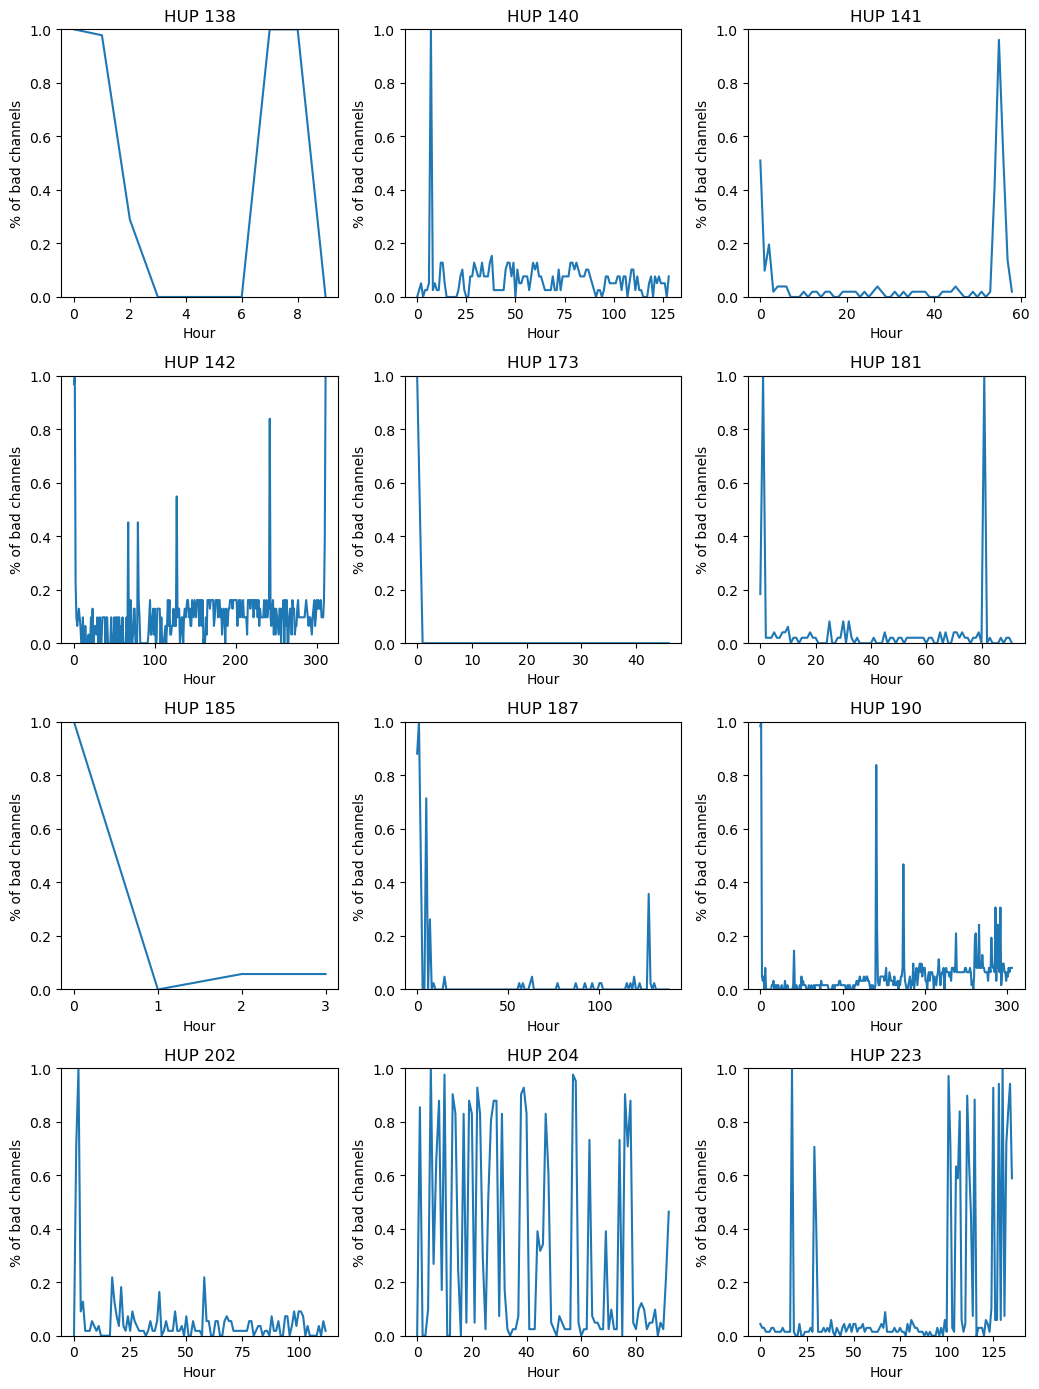

In [42]:
# Determine number of rows and columns for subplots
num_plots = len(datasets_df)
num_cols = 3
num_rows = math.ceil(num_plots / num_cols)

# Create a figure with a subplot for each row in datasets_df
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3.5, num_rows * 3.5))

# Flatten the axis array for easy iteration, and iterate only up to num_plots
axs = axs.flatten()[:num_plots]

# Iterate over each row of datasets_df
for i, row in datasets_df.iterrows():
    patient_hup_id = row["hup_id"]
    max_hour = row["max_hour"]
    sample_rate = row["sample_rate"]

    percent_of_bad_channels = []

    for hour in range(max_hour + 1):
        filename = f"HUP_{patient_hup_id}_hr_{hour}_fs_{sample_rate}.pkl"
        with open(f"{directory_path}{filename}", "rb") as f:
            eeg_segment_df = pickle.load(f)

        channel_labels = eeg_segment_df.columns.to_numpy(dtype=str)
        channel_indices = np.arange(len(channel_labels))

        bad_channel_indicies, bad_details = identify_bad_channels(
            eeg_segment_df.to_numpy(dtype=float),
            channel_indices,
            channel_labels,
            sample_rate,
        )
        percent_of_bad_channels.append(len(bad_channel_indicies) / len(channel_indices))

    assert len(percent_of_bad_channels) == max_hour + 1

    # plot the number of bad channels for this patient over x axis which is the hour
    axs[i].plot(percent_of_bad_channels)
    axs[i].set_title(f"HUP {patient_hup_id}")
    axs[i].set_xlabel("Hour")
    axs[i].set_ylabel("% of bad channels")
    axs[i].set_ylim([0, 1])

# Adjust layout and display
plt.tight_layout()
plt.show()

**Conclusions:**
1. Lots of "bad" channels during the first couple hours of EEG recording.
2. Maybe those "bad" channels have contaminated my previous analysis?

#### 3.2.3: First Pass with Bipolar Re-Referencing

HUP138 has rid 278
HUP138 has ['HUP138_phaseII'] datasets
['lacosamide', 'levetiracetam', 'lorazepam']
38
Doses: Start time: 22.716666666666665 hr, End time: 190.15 hr
6 9 9
Processing frequency range 50-75
Processing EEG data...
Length of processed_data: 6
Calculating Kuramoto order parameter...


IndexError: index 6 is out of bounds for axis 0 with size 6

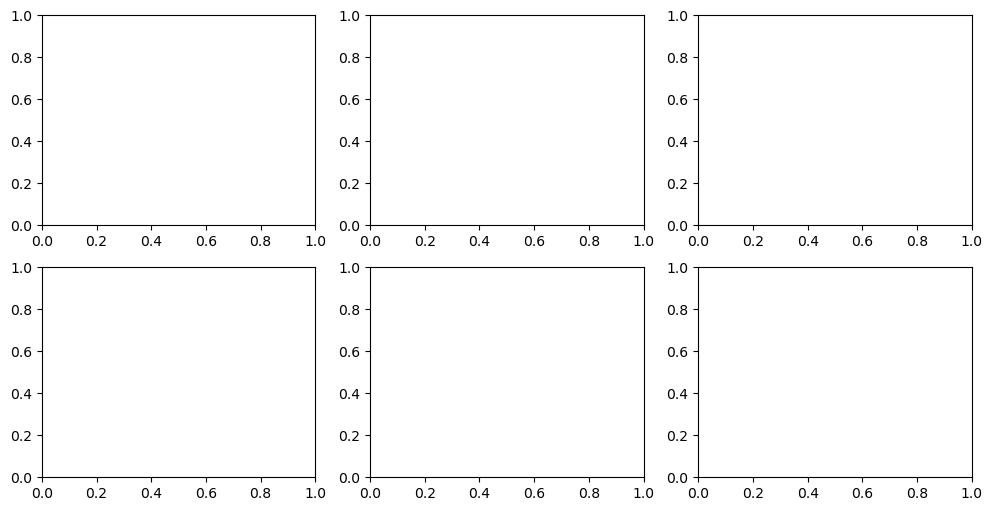

In [21]:
for i, row in patients_df.iterrows():
    # Get patient id and weight
    patient_hup_id, patient_weight = row["hup_id"], row["weight_kg"]
    patient_idx = patient_hup_id_to_index[patient_hup_id]

    # Run matlab script
    # Find the ieeg_start value for patient_hup_id in ieeg_starts_df and convert it into float
    ieeg_start_hrs = float(
        ieeg_starts_df.loc[
            ieeg_starts_df["hup_id"] == patient_hup_id, "ieeg_start"
        ].values[0]
    )
    aligned_emu_start_time_hrs = round(ieeg_start_hrs)

    seizure_times_sec = np.array(
        eng.get_seizure_times(f"HUP{patient_hup_id}", nargout=2)[0]
    )

    seizure_times_sec = seizure_times_sec + (ieeg_start_hrs * 3600)

    #########################################
    # Check tables
    #########################################
    if rid_hup_table_df.loc[rid_hup_table_df["hupsubjno"] == patient_hup_id].empty:
        print(f"HUP{patient_hup_id} has no info on rid_hup_table sheet")
        continue

    patient_rid = int(
        rid_hup_table_df.loc[rid_hup_table_df["hupsubjno"] == patient_hup_id].record_id
    )

    print(f"HUP{patient_hup_id} has rid {patient_rid}")

    patient_electrodes_df = master_elecs_df.loc[master_elecs_df["rid"] == patient_rid]

    if patient_electrodes_df.empty:
        print(f"HUP{patient_hup_id} has no info on master electrode sheet")
        continue

    #########################################
    # Get ieeg dataset name
    #########################################
    ieeg_dataset_names = []
    # Check if ieeg_offset_row1_df[patient_idx] is all NaNs
    if ieeg_offset_row1_df[patient_idx].isnull().values.all():
        ieeg_dataset_names = [f"HUP{patient_hup_id}_phaseII"]
    else:
        ieeg_dataset_names = ieeg_offset_row1_df[patient_idx].dropna().to_list()

    print(f"HUP{patient_hup_id} has {str(ieeg_dataset_names)} datasets")

    if len(ieeg_dataset_names) > 1:
        continue

    if len(datasets_df.loc[datasets_df["hup_id"] == patient_hup_id]) == 0:
        print(f"HUP{patient_hup_id} has no info on datasets_df")
        continue

    # Get max_hour value of HUP id in datasets_df
    max_hour = int(datasets_df.loc[datasets_df["hup_id"] == patient_hup_id].max_hour)
    sample_rate = int(
        datasets_df.loc[datasets_df["hup_id"] == patient_hup_id].sample_rate
    )

    #########################################
    # Get AED dose
    #########################################
    # Assign results to variables
    all_dose_curves = dose_curves_res[i]
    all_tHr = tHr_res[i]
    all_med_names = med_names_res[i]

    print(all_med_names)

    assert (
        len(all_dose_curves) == len(all_tHr) == len(all_med_names)
    ), "all_dose_curves, all_tHr, and all_med_names should have the same length"

    # Process numpy arrays
    all_med_names_plot = np.array(all_med_names).flatten()

    tmp = []
    for dose in all_dose_curves:
        dose = np.array(dose).flatten()
        tmp.append(dose)
    all_dose_curves_plot = np.array(tmp, dtype=object)

    tmp = []
    for dose in all_tHr:
        dose = np.array(dose).flatten()
        tmp.append(dose)
    all_tHr_plot = np.array(tmp, dtype=object)

    # Get the last element of each array in all_tHr_plot and test if they're the same
    # They should be the same because they're the same patient
    assert all(
        [all_tHr_plot[i][-1] == all_tHr_plot[0][-1] for i in range(len(all_tHr_plot))]
    ), "The last element of each array in all_tHr_plot should be the same"

    # Construct the time axis
    emu_start_time_hrs = min([all_tHr_plot[i][0] for i in range(len(all_tHr_plot))])
    emu_end_time_hrs = all_tHr_plot[0][-1]
    max_dose_duration_hrs = emu_end_time_hrs - emu_start_time_hrs
    max_length = max([len(all_tHr_plot[i]) for i in range(len(all_tHr_plot))])
    time_axis = np.linspace(emu_start_time_hrs, emu_end_time_hrs, max_length)
    print(aligned_emu_start_time_hrs)
    # Print start and end times in one line
    print(
        f"Doses: Start time: {emu_start_time_hrs} hr, End time: {emu_end_time_hrs} hr"
    )

    sum_array = []

    # Create two subplots with shared x-axis
    # fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(9, 8))

    #########################################
    # Plot dose curves
    #########################################
    for med_idx, med_name in enumerate(all_med_names_plot):
        dose_times = all_tHr_plot[med_idx].flatten()

        # Find Avg for medication med_name in aed_ref_ranges_df
        if med_name == "lorazepam":
            ref_range = 1
        else:
            ref_range = float(
                aed_ref_ranges_df.loc[
                    aed_ref_ranges_df["Drug"] == med_name, "Avg"
                ].values[0]
            )

        # Normalize dose curve according to the middle of the reference range
        dose = all_dose_curves_plot[med_idx].flatten()
        dose = dose / ref_range

        interp_func = interpolate.interp1d(
            dose_times, dose, bounds_error=False, fill_value=0
        )
        dose_interp = interp_func(time_axis)

        if med_name != "lorazepam":
            sum_array.append(dose_interp)

        # ax1.plot(time_axis, dose_interp, label=med_name.capitalize())

    # Add legends to the curves
    # ax1.legend()
    # ax1.set(title=f"AEDs for HUP {patient_hup_id}", ylabel="Normalized Dose")

    cumulative_dose_curve = np.sum(sum_array, axis=0)

    # # Compute the average dosages per hour
    # average_dosages = average_dose_per_hour(time_axis, cumulative_dose_curve)

    # # Plot the average dosages
    # plot_average_doses(average_dosages)

    # cumulative_dose_curve = cumulative_dose_curve / cumulative_dose_curve.max()
    assert len(cumulative_dose_curve) == len(
        time_axis
    ), "cumulative_dose_curve and time_axis should have the same length"

    # Convert numpy arrays to pandas DataFrame
    df = pd.DataFrame(data={"Time": time_axis, "Value": cumulative_dose_curve})
    # Create a new column for the integer hour
    df["Hour"] = df["Time"].astype(int)

    # Group by hour and compute mean
    hourly_df = df.groupby("Hour").mean()
    # Create a new column for the day
    df["Day"] = (df["Time"] // 24).astype(int)
    # Group by day and compute mean
    daily_df = df.groupby("Day").mean()

    # Create an array for mean values repeated for each hour
    mean_values_repeated = np.repeat(
        daily_df["Value"].values, df.groupby("Day").size().values
    )
    assert len(mean_values_repeated) == len(
        cumulative_dose_curve
    ), "mean_values_repeated and cumulative_dose_curve should have the same length"

    # Add label to the cumulative dose curve and plot it on the second subplot
    # ax2.plot(time_axis, cumulative_dose_curve, label="Cumulative dose", color="black")
    # ax2.plot(
    #     time_axis, mean_values_repeated, label="Daily mean cumul dose", color="red"
    # )
    # ax2.legend()
    # ax2.set(
    #     title=f"Cumulative Dose for HUP {patient_hup_id}",
    #     xlabel="Time (hours)",
    #     ylabel="Normalized dose",
    # )

    # for seizure_time in seizure_times:
    #     seizure_time = int(seizure_time[0] / 3600 + aligned_emu_start_time_hrs)
    #     ax1.axvline(x=seizure_time, color="red", linestyle="--")
    #     ax2.axvline(x=seizure_time, color="red", linestyle="--")
    #     ax3.axvline(x=seizure_time, color="red", linestyle="--")

    # # Above each day, plot day number
    # for day in range(1, int(max_dose_duration_hrs / 24) + 1):
    #     # ax2.axvline(x=day * 24, color="gray", linestyle="--")
    #     ax3.text(
    #         day * 24,
    #         1.1,
    #         f"Day {day}",
    #         horizontalalignment="center",
    #         verticalalignment="center",
    #         transform=ax3.get_xaxis_transform(),
    #     )

    #########################################
    # Load iEEG data from ./data
    #########################################

    hourly_eeg = []
    eeg_end_time_hrs = max_hour
    selected_eeg_hours = []

    for hour in range(max_hour + 1):
        filename = f"HUP_{patient_hup_id}_hr_{hour}_fs_{sample_rate}.pkl"
        with open(f"{directory_path}{filename}", "rb") as f:
            eeg_segment_df = pickle.load(f)

        channel_labels = eeg_segment_df.columns.to_numpy(dtype=str)
        channel_indices = np.arange(len(channel_labels))

        bad_channel_indicies, bad_details = identify_bad_channels(
            eeg_segment_df.to_numpy(dtype=float),
            channel_indices,
            channel_labels,
            sample_rate,
        )

        # Get the labels of the good indicies
        good_channel_labels = np.delete(channel_labels, bad_channel_indicies)

        # Skip this hour if there are less than 2 good channels, i.e., unable to create a bipolar montage
        if len(good_channel_labels) < 2:
            continue

        bad_channel_labels = channel_labels[bad_channel_indicies]

        # get the data in eeg_segment_df that corresponds to the good channels
        good_channels_eeg_segment_df = eeg_segment_df[good_channel_labels]

        local_res = create_bipolar_montage(
            good_channels_eeg_segment_df.to_numpy(dtype=float), good_channel_labels
        )

        # Check if local_res has at least two columns, i.e., at least two good channels in the bipolar montage, otherwise skip this hour
        if local_res is None:
            print(f"Skipping hour {hour} because bipolar montage is None")
            continue

        if local_res.shape[1] < 2:
            print(
                f"Skipping hour {hour} because bipolar montage has less than 2 channels"
            )
            continue

        # These are the data we'll process
        hourly_eeg.append(local_res)
        selected_eeg_hours.append(hour)

    if len(selected_eeg_hours) == 0:
        continue

    #########################################
    # Time alignment
    #########################################

    # Create an array starting from aligned_emu_start_time_hrs for the length of processed_hourly_eeg
    # eeg_hours = np.arange(0, eeg_end_time_hrs)
    eeg_hours = np.array(selected_eeg_hours)
    emu_hours = hourly_df.index.values

    emu_hrs_in_consideration = np.arange(
        aligned_emu_start_time_hrs,
        min(emu_hours[-1], (eeg_hours + aligned_emu_start_time_hrs)[-1]),
    )
    eeg_hrs_in_consideration = (
        emu_hrs_in_consideration - (eeg_hours + aligned_emu_start_time_hrs)[0]
    )

    print(
        len(selected_eeg_hours),
        len(emu_hrs_in_consideration),
        len(eeg_hrs_in_consideration),
    )

    assert len(emu_hrs_in_consideration) == len(
        eeg_hrs_in_consideration
    ), "emu_hrs_in_consideration and eeg_hrs_in_consideration should have the same length"

    # Create a new plot of 6 subplots (2 rows, 3 columns)
    frequencies = [(50, 75), (75, 100), (100, 125), (125, 150), (150, 175), (175, 200)]
    fig_regression, axs_regression = plt.subplots(2, 3, figsize=(12, 6))

    if sample_rate == 256:
        frequencies = [(50, 75), (75, 100), (100, 125)]
        fig_regression, axs_regression = plt.subplots(1, 3, figsize=(12, 3))

    for fr_idx, frequency in enumerate(frequencies):
        frequency_range_str = f"{frequency[0]}-{frequency[1]}"
        print(f"Processing frequency range {frequency_range_str}")

        #########################################
        # Use process_eeg_data to process each column of test_data
        #########################################

        print("Processing EEG data...")
        processed_hourly_eeg = []
        for eeg_df in hourly_eeg:
            local_df = eeg_df.apply(
                lambda x: process_eeg_data(x, sample_rate, band_pass_freq=frequency),
                axis=0,
            )
            processed_hourly_eeg.append(local_df)

        print(f"Length of processed_data: {len(processed_hourly_eeg)}")

        hourly_synchrony = []
        daily_sync = []

        #########################################
        # Calculate synchrony
        #########################################

        print("Calculating Kuramoto order parameter...")
        hourly_synchrony = [
            calculate_kuramoto_order_parameter(eeg_df.T).mean()
            for eeg_df in processed_hourly_eeg
        ]

        #########################################
        # Prepare regression data
        #########################################

        dose_for_regression = hourly_df.loc[emu_hrs_in_consideration]["Value"].values
        synchrony_for_regression = np.array(hourly_synchrony)[eeg_hrs_in_consideration]
        assert len(dose_for_regression) == len(
            synchrony_for_regression
        ), "dose_for_regression and synchrony_for_regression should have the same length"

        hourly_regression_df = pd.DataFrame(
            {
                "Hour": emu_hrs_in_consideration,
                "Dose": dose_for_regression,
                "Synchrony": synchrony_for_regression,
            }
        )
        hourly_regression_df["Day"] = (hourly_regression_df["Hour"] // 24).astype(int)
        daily_regression_df = (
            hourly_regression_df.groupby("Day").mean().drop(columns=["Hour"])
        )

        # Plot synchrony vs dose
        # ax3.plot(emu_hrs_in_consideration, synchrony_for_regression, "o")

        # # Save the figure
        # fig.savefig(
        #     f"./results/{frequency_range_str}/{patient_id}_dose_{frequency[0]}_{frequency[1]}.png"
        # )

        # Fit a linear regression model to synchrony_for_regression and dose_for_regression using SciPy
        print("Fitting linear regression model...")
        if len(dose_for_regression) == 0 or len(synchrony_for_regression) == 0:
            print("No data for linear regression")
            continue

        slope, intercept, r_value, p_value, std_err = stats.linregress(
            dose_for_regression, synchrony_for_regression
        )
        print(
            f"slope: {slope}, intercept: {intercept}, r_value: {r_value}, p_value: {p_value}, std_err: {std_err}"
        )

        # Plot the linear regression model...
        print("Plotting linear regression model...")
        predicted_synchrony = intercept + slope * dose_for_regression
        if sample_rate == 256:
            ax = axs_regression[fr_idx]
        else:
            ax = axs_regression[fr_idx // 3, fr_idx % 3]
        ax.plot(
            dose_for_regression, synchrony_for_regression, "o", label="Original Data"
        )
        ax.plot(dose_for_regression, predicted_synchrony, "r", label="Fitted Line")
        ax.legend()

        # Add text for p value, r value, and slope
        textstr = "\n".join(
            (
                r"$slope=%.2f$" % (slope,),
                r"$r-value=%.2f$" % (r_value,),
                r"$p-value=%.2f$" % (p_value,),
            )
        )
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment="top",
            bbox=props,
        )

        ax.set(
            title=f"HUP {patient_hup_id} ({frequency_range_str}Hz)",
            xlabel="Dose",
            ylabel="R",
        )

    fig_regression.tight_layout()
    plt.show()

    # # Fit a linear regression model to dose and synchrony using SciPy
    # if len(daily_regression_df) == 0:
    #     print("No data for daily linear regression")
    #     continue

In [23]:
hourly_synchrony

[0.2617518361992781,
 0.15854015332907637,
 0.13259498479435997,
 0.13020362736432703,
 0.12660652770563588,
 0.12013650670416226]